# Advanced ML Project
---

## Summary

1. **Transformers with Attention Mechanisms**
    - **Project**: Develop a specialized Transformer model to capture long-term dependencies and temporal relationships in financial data, based on "Attention is All You Need" by Vaswani et al. (2017). We could also use the Temporal Fusion Transformer (TFT) for its efficiency with multi-horizon series, as presented by Lim et al. in "Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting" (2021).
    - **Objective**: Improve prediction accuracy by using attention mechanisms to capture the influences of distant data points.

2. **Variational Autoencoders (VAE) for Feature Engineering and Anomaly Detection**
    - **Project**: Use VAEs to compress market data and extract latent representations less sensitive to noise, inspired by "Auto-Encoding Variational Bayes" by Kingma and Welling (2013). We will also explore VAE-based approaches for anomaly detection in time series, as detailed in "Robust Anomaly Detection for Multivariate Time Series through Stochastic Recurrent Neural Network" by Hundman et al. (2018).
    - **Objective**: Extract robust latent features and detect anomalies to improve predictions and identify unexpected market variations.

3. **Performance Comparison**
    - **Objective**: Compare the performance of the two methods (Transformers vs VAE) for time series forecasting.

4. **Hyperparameter Fine-Tuning**
    - **Objective**: Fine-tune the model hyperparameters to optimize prediction performance.

https://github.com/xuxu-wei/HybridVAE

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [303]:
from transformers import TimeSeriesTransformerForPrediction
#from lightning.pytorch import Trainer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.loggers import TensorBoardLogger


## Loading data

In [219]:
df = pd.read_parquet('../preprocessed_data/training.parquet').dropna()
test_df = pd.read_parquet('../preprocessed_data/test.parquet')

In [233]:
df.drop(columns="responder_6_lag_1", inplace=True)

In [305]:
# Samples to try the algo
df_small = df.iloc[-500000:]
test_df_small = test_df.sample(100000).dropna()

In [306]:
test_df_small

,id,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,...,label,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
335594,46935372,1693,860,38,2.854656,3.214393,-0.584847,3.289541,2.728956,-0.201064,...,0,-0.368417,-0.532117,-1.799991,0.084960,0.026816,-0.455079,0.327292,0.263015,0.497859
136187,46735965,1688,587,38,3.278609,3.384902,-0.193709,3.874621,3.343481,-0.075283,...,0,-0.262724,0.072253,0.119085,-0.035241,-0.033427,0.103239,-0.022854,0.015629,-0.085243
123345,46723123,1688,258,27,1.978096,3.390928,-0.108632,3.360468,3.256377,-0.124128,...,0,-0.544125,-0.071468,-0.318722,-0.223752,-0.160193,0.298253,0.204016,0.126124,0.410063
444809,47044587,1696,777,11,1.748166,2.368846,-0.710601,2.734649,2.126140,-0.268404,...,0,-0.532444,0.098892,0.966809,0.417199,0.241041,0.522957,0.008331,0.035156,0.004970
262079,46861857,1691,911,38,3.028034,2.812776,-0.039425,2.994819,2.936656,-0.132411,...,0,-0.050007,0.279277,1.290365,0.038503,0.023583,0.592896,-0.170020,-0.023192,-0.300870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246708,46846486,1691,517,33,1.197254,2.934187,-0.196961,3.017119,3.089595,-0.344513,...,0,1.225500,0.581439,0.853549,-0.206464,-0.084373,0.237839,-0.053865,0.001165,-0.095834
319426,46919204,1693,446,16,4.651937,2.704496,-1.714473,3.368670,3.725866,0.712718,...,0,-0.200018,0.417554,-0.097555,0.414277,0.243810,0.231836,0.116222,0.112058,0.265302
467847,47067625,1697,404,35,0.956365,2.283567,-0.378630,1.816175,2.158223,-0.481388,...,-2,1.407528,0.396527,-0.489022,-5.000000,-2.126582,-5.000000,0.058946,0.071137,0.116078
480905,47080683,1697,739,28,1.377110,2.092795,0.326302,1.834910,1.995446,-0.605290,...,0,-0.821258,-1.112829,0.138508,-5.000000,-4.947656,-5.000000,0.176841,0.110973,0.401314


In [307]:
max_encoder_length = 50  # lookback window
max_prediction_length = 10  # forecast window
#training_cutoff = int(len(df) * 0.8)

In [308]:
df_small["symbol_id"] = df_small["symbol_id"].astype("str")
test_df_small["symbol_id"] = test_df_small["symbol_id"].astype("str")
#val_df_small["symbol_id"] = val_df_small["symbol_id"].astype("str")

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_86549/266678574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small["symbol_id"] = df_small["symbol_id"].astype("str")


In [73]:
df_small.dtypes

id                    uint32
date_id                int32
time_id                int16
symbol_id             object
weight               float32
                      ...   
responder_5_lag_1    float32
responder_6_lag_1    float32
responder_7_lag_1    float32
responder_8_lag_1    float32
time_idx               int16
Length: 104, dtype: object

## Benchmark linear regression

In [133]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [134]:
df_small = df.dropna().sample(1000000)

In [101]:
df_small

,id,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,...,label,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
2128308,43756438,1608.0,364,0,3.937173,2.306764,0.519196,2.637494,2.254404,-0.841473,...,0.0,-0.162277,-0.116389,1.560023,0.979339,0.343606,0.846384,0.210039,0.088136,0.334838
1714380,43342510,1597.0,109,0,4.475202,-0.058088,-2.612298,-0.046534,0.057987,-1.318175,...,0.0,1.592873,1.349861,0.034853,1.579569,0.825219,1.455915,0.738635,0.376521,1.107516
2649701,44277831,1622.0,364,5,3.011554,1.774683,-1.365354,1.586449,1.855868,0.517707,...,0.0,1.264722,0.778407,-0.526852,0.241921,0.177216,0.372287,0.144821,0.096059,0.245909
3989011,45617141,1658.0,518,9,1.194727,1.728448,0.056828,2.213796,2.091799,-1.545495,...,0.0,-0.106015,0.136787,0.622785,0.089944,0.067552,-0.290040,-1.256863,-0.516847,-3.350451
3119651,44747781,1634.0,838,17,3.891044,0.739156,0.923295,0.571764,0.298341,-0.360414,...,0.0,-0.615973,-0.177908,-0.086522,-0.439819,-0.191102,-0.016968,-0.371733,-0.204741,-0.872424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080413,44708543,1633.0,800,13,2.670314,0.455579,0.923407,0.319387,0.632010,0.082968,...,3.0,0.327784,0.268779,1.165349,0.699005,0.443276,1.196272,0.697565,0.234190,1.262335
963786,42591916,1576.0,884,30,2.354905,2.320300,-1.297566,2.499391,2.726670,1.380740,...,0.0,1.309887,0.979838,1.944776,0.420354,0.166707,-0.033193,-0.340363,-0.069098,-0.533852
4448471,46076601,1670.0,828,24,1.294774,-0.114172,-1.025281,0.161494,0.267733,-1.050663,...,0.0,0.376283,-0.302141,-0.045680,0.456144,0.184020,-0.004782,-0.003736,0.015292,-0.024052
2291974,43920104,1612.0,706,26,1.639267,2.598802,-1.028428,1.620213,1.803322,-0.750055,...,0.0,0.428165,0.269177,0.118191,-0.301266,-0.128761,-0.843805,-0.831479,-0.384089,-1.556916


In [135]:
model = LinearRegression()
model.fit(df_small.drop(columns=["label"]), df_small["label"])

LinearRegression()

In [136]:
val_index = [e for e in df.index if e not in df_small.index]
df_val = df.loc[val_index].dropna().sample(100000)

In [137]:
r_sq = model.score(df_small.drop(columns=["label"]), df_small["label"])
print('coefficient of determination:', r_sq)

coefficient of determination: 0.9071758644357212


In [138]:
y_pred = model.predict(df_val.drop(columns=["label"]))
rms = mean_squared_error(df_val["label"], y_pred)

In [144]:
rms

0.1493276222104628

In [139]:
predi = pd.DataFrame(y_pred, columns=["predicted"])
predi['true'] = df_val["label"].values
predi

,predicted,true
0,-0.132206,0
1,0.255899,0
2,0.393128,0
3,-0.951314,-1
4,0.111899,0
...,...,...
99995,1.216222,1
99996,-0.073650,0
99997,-0.789667,-1
99998,-0.885828,-1


## Training Temporal Fusion Transformers

### Creation of an unique time id column for TimeSeriesDataSet

In [309]:
mapping = pd.DataFrame(pd.concat([df,test_df]).groupby(['date_id','time_id']).count().index,columns=["date_time"]).reset_index().rename(columns={"index":"time_idx"})

In [277]:
mapping

,time_idx,date_time
0,0,"(1552, 68)"
1,1,"(1552, 69)"
2,2,"(1552, 70)"
3,3,"(1552, 71)"
4,4,"(1552, 72)"
...,...,...
132347,132347,"(1698, 963)"
132348,132348,"(1698, 964)"
132349,132349,"(1698, 965)"
132350,132350,"(1698, 966)"


In [310]:
df_small["date_time"] = list(zip(df_small["date_id"], df_small["time_id"]))
df_small["time_idx"] = df_small["date_time"].map(dict(zip(mapping["date_time"], mapping["time_idx"])))

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_86549/2417218599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small["date_time"] = list(zip(df_small["date_id"], df_small["time_id"]))
/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_86549/2417218599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small["time_idx"] = df_small["date_time"].map(dict(zip(mapping["date_time"], mapping["time_idx"])))


In [311]:
test_df_small["date_time"] = list(zip(test_df_small["date_id"], test_df_small["time_id"]))
test_df_small["time_idx"] = test_df_small["date_time"].map(dict(zip(mapping["date_time"], mapping["time_idx"])))

In [312]:
first_val = df_small["time_idx"].min()

In [313]:
df_small['time_idx'] = df_small['time_idx']-first_val
test_df_small['time_idx'] = test_df_small['time_idx']-first_val

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_86549/1245178943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['time_idx'] = df_small['time_idx']-first_val


In [11]:
df_small.isna().sum().sum()

0

In [198]:
df_small.describe()

,id,date_id,time_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_7_lag_1,responder_8_lag_1,time_idx,time_idx_2
count,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,4.657321e+07,1683.684000,592.229720,1.989610,3.227522,-0.109737,3.214889,3.214286,-0.084449,-0.217516,...,0.139762,0.139813,0.148102,0.084448,0.042563,0.089323,0.011148,-0.088894,2275.913720,659.17028
std,1.592014e+04,0.464918,251.119804,0.909354,0.300719,0.815849,0.300416,0.300179,0.640345,0.709463,...,0.901758,0.478356,0.881593,0.556480,0.244032,0.417234,0.101158,0.457286,250.916599,382.27245
min,4.654537e+07,1683.000000,68.000000,0.702595,1.952113,-2.421601,1.915817,1.968258,-2.727498,-4.481705,...,-2.663801,-1.111050,-2.362758,-1.229572,-0.503404,-1.009007,-0.243303,-1.199404,1752.000000,0.00000
25%,4.655855e+07,1683.000000,396.000000,1.217208,3.024758,-0.664834,3.011751,3.012015,-0.544856,-0.524173,...,-0.367741,-0.173446,-0.380127,-0.131301,-0.064531,-0.170024,-0.042360,-0.323712,2080.000000,328.00000
50%,4.657412e+07,1684.000000,634.000000,1.952800,3.227493,-0.133677,3.215489,3.213831,-0.090082,-0.133825,...,0.162484,0.035862,-0.028620,0.091651,0.053591,0.122405,0.004071,-0.100084,2318.000000,657.00000
75%,4.658695e+07,1684.000000,801.000000,2.531363,3.429349,0.398711,3.415995,3.416494,0.371238,0.182307,...,0.684143,0.421848,0.621562,0.350158,0.166294,0.274269,0.072348,0.169723,2484.000000,989.00000
max,4.659978e+07,1684.000000,967.000000,4.677842,4.442627,3.012100,4.383210,4.357268,2.148427,2.898562,...,2.467610,1.522810,3.424407,2.347394,0.743473,1.421510,0.356702,1.615337,2651.000000,1327.00000


In [165]:
df_small

,id,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,...,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_7_lag_1,responder_8_lag_1,time_idx,date_time,new_col
4414087,46042217,1669,891,30,1.690181,0.007090,-0.482614,0.244307,0.440378,1.420072,...,-0.399602,-0.504502,-0.210983,-0.118711,-0.470913,-0.019774,-0.271890,0,"(1669, 891)",0
4414088,46042218,1669,891,31,0.715662,0.540215,-0.634153,0.769046,0.571708,1.188633,...,0.520475,0.876531,-0.101602,-0.032214,-0.674036,-0.104636,-0.739772,0,"(1669, 891)",0
4414089,46042219,1669,891,32,1.524050,0.383557,-0.567525,0.847890,0.696430,0.876198,...,-0.186472,-0.413349,0.031786,0.020555,-0.031585,-0.008285,-0.177291,0,"(1669, 891)",0
4414090,46042220,1669,891,33,1.386579,0.198206,-0.273108,-0.561643,0.272005,0.886292,...,-1.020017,-0.077395,0.253451,0.150415,-0.131873,-0.004737,-0.236067,0,"(1669, 891)",0
4414091,46042221,1669,891,34,2.722149,-0.174607,-0.724030,0.578088,0.710770,0.674784,...,-0.047733,-0.230586,0.145945,0.104809,-0.177008,0.022756,-0.076810,0,"(1669, 891)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4971642,46599772,1684,967,33,1.260113,2.854824,-0.182001,3.030202,2.955101,-0.034863,...,0.680279,0.839948,0.411006,0.187644,0.273078,-0.016302,-0.182008,13576,"(1684, 967)",13576
4971643,46599773,1684,967,34,2.364175,3.328318,0.004640,3.429580,2.893713,0.575843,...,0.091131,-0.555067,-0.374748,-0.135764,-0.168106,0.041251,0.005263,13576,"(1684, 967)",13576
4971644,46599774,1684,967,35,0.971465,3.334346,-0.092881,3.382863,3.111636,0.644229,...,0.792256,-0.687760,0.040876,0.033282,0.122405,0.026679,-0.025678,13576,"(1684, 967)",13576
4971646,46599776,1684,967,37,1.306336,3.129787,-0.023663,3.379802,3.387269,0.109540,...,0.304786,-0.029890,1.104309,0.650506,0.459980,-0.007395,-0.160535,13576,"(1684, 967)",13576


In [314]:
columns_to_drop = ["id","date_id",'time_id',"date_time"]
df_small.drop(columns=columns_to_drop, inplace=True)
test_df_small.drop(columns=columns_to_drop, inplace=True)

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_86549/3419571085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.drop(columns=columns_to_drop, inplace=True)


In [239]:
df_small

,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,...,label,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_7_lag_1,responder_8_lag_1,time_idx
4414087,30,1.690181,0.007090,-0.482614,0.244307,0.440378,1.420072,0.640939,-0.090522,1.332146,...,-4,-0.357139,-0.399602,-0.504502,-0.210983,-0.118711,-0.470913,-0.019774,-0.271890,0
4414088,31,0.715662,0.540215,-0.634153,0.769046,0.571708,1.188633,0.720958,-0.158161,1.120538,...,-3,1.135520,0.520475,0.876531,-0.101602,-0.032214,-0.674036,-0.104636,-0.739772,0
4414089,32,1.524050,0.383557,-0.567525,0.847890,0.696430,0.876198,0.443820,-0.097515,0.714503,...,-1,-0.295801,-0.186472,-0.413349,0.031786,0.020555,-0.031585,-0.008285,-0.177291,0
4414090,33,1.386579,0.198206,-0.273108,-0.561643,0.272005,0.886292,0.529212,-0.084445,1.192398,...,2,-2.134588,-1.020017,-0.077395,0.253451,0.150415,-0.131873,-0.004737,-0.236067,0
4414091,34,2.722149,-0.174607,-0.724030,0.578088,0.710770,0.674784,1.204417,-0.221221,1.627897,...,0,-0.075389,-0.047733,-0.230586,0.145945,0.104809,-0.177008,0.022756,-0.076810,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4971642,33,1.260113,2.854824,-0.182001,3.030202,2.955101,-0.034863,0.020673,0.583853,0.127877,...,0,1.421281,0.680279,0.839948,0.411006,0.187644,0.273078,-0.016302,-0.182008,13576
4971643,34,2.364175,3.328318,0.004640,3.429580,2.893713,0.575843,0.044370,1.525104,0.242329,...,0,0.557703,0.091131,-0.555067,-0.374748,-0.135764,-0.168106,0.041251,0.005263,13576
4971644,35,0.971465,3.334346,-0.092881,3.382863,3.111636,0.644229,0.016599,0.837059,0.181541,...,0,0.923129,0.792256,-0.687760,0.040876,0.033282,0.122405,0.026679,-0.025678,13576
4971646,37,1.306336,3.129787,-0.023663,3.379802,3.387269,0.109540,0.028464,1.360380,0.178313,...,0,0.568908,0.304786,-0.029890,1.104309,0.650506,0.459980,-0.007395,-0.160535,13576


In [315]:
time_varying_unknown_reals = df_small.drop(columns=["label","symbol_id","time_idx"]).columns.to_list()

In [316]:
training = TimeSeriesDataSet(
    df_small,
    time_idx="time_idx",
    target="label",
    group_ids=["symbol_id"],
    min_encoder_length=max_encoder_length // 2,  # allow predictions without history
    max_encoder_length=max_encoder_length,
    min_prediction_idx=0,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["symbol_id"],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=[],
    time_varying_unknown_reals=time_varying_unknown_reals,
    #target_normalizer=GroupNormalizer(transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
)

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:572: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)


In [317]:
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)

validation = TimeSeriesDataSet.from_dataset(training, df_small, predict=True, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=64 * 10, num_workers=0)

test_dataloader = TimeSeriesDataSet.from_dataset(training, test_df_small,categorical_encoders={"symbol_id": NaNLabelEncoder(add_nan=True)},predict=True, stop_randomization=True).to_dataloader(train=False, batch_size=64 * 10, num_workers=0)

In [175]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_86549/296535705.py:1: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save

tensor(0.5737)

In [75]:
pl.seed_everything(42)
trainer = pl.Trainer(
    #accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [206]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    #hidden_size=8, 
    #attention_head_size=4,
    #dropout=0.1,
    #hidden_continuous_size=8,
    #loss=RMSE(),
    #optimizer="Ranger",
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. Fr

Number of parameters in network: 84.1k


In [335]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/loops/training_epoch_loop.py:161: You're resuming from a checkpoint that ended before the epoch ended and your dataloader is not resumable. This can cause unreliable results if further training is done. Consider using an end-of-epoch checkpoint or make your dataloader resumable by implementing the `state_dict` / `load_state_dict` interface.
Finding best initial lr:   1%|          | 1/100 [00:00<00:53,  1.86it/s]
LR finder stopped early after 35 steps due to diverging loss.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Restoring states from the checkpoint path at /Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/code/.lr_find_6e5db7ea-88d1-44b1-8b7b-78ae0d40cff1.ckpt
Restored all states from the checkpoint at /Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/code/

suggested learning rate: None


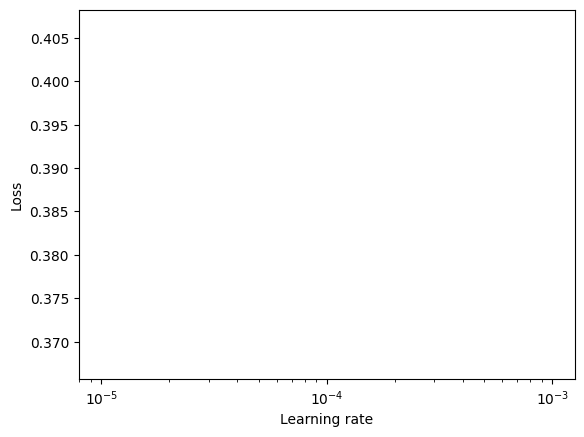

/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_86549/3629428528.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [333]:
#res = Tuner(trainer).lr_find(
#    tft,
#    train_dataloaders=train_dataloader,
#    val_dataloaders=val_dataloader,
#    max_lr=1,
#    min_lr=1e-4,
#    num_training=100,
#)

#print(f"suggested learning rate: {res.suggestion()}")
#fig = res.plot(show=True, suggest=True)
#fig.show()

In [336]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.030199517204020164,
    #hidden_size=16,
    #attention_head_size=4,
    #dropout=0.1,
    #hidden_continuous_size=8,
    #loss=RMSE(),
    #log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    #optimizer="Ranger",
    #reduce_on_plateau_patience=4,
    #output_size = 21,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. Fr

Number of parameters in network: 84.1k


In [337]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 456    | train
3  | prescalers                         | ModuleDict                      | 1.6 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 646    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 68.7 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528    | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/Users/paul-antoine/Desktop/ENSAE/Advanced-ML-Project/.venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 50/50 [00:31<00:00,  1.58it/s, v_num=20, train_loss_step=0.454, val_loss=0.335, train_loss_epoch=0.439]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s, v_num=20, train_loss_step=0.454, val_loss=0.335, train_loss_epoch=0.439]
